In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
import librosa.display
import random

In [ ]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'/content/drive/MyDrive/Data/genres_original/{genre}'):
        songname = f'/content/drive/MyDrive/Data/genres_original/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_fft=512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append((ps, genre_number))

print(len(dataset))

13986


**分割資料集**

In [ ]:
random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape((64, 173, 1)) for x in X_train])
X_valid = np.array([x.reshape((64, 173, 1)) for x in X_valid])
X_test = np.array([x.reshape((64, 173, 1)) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(tf.keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(tf.keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(tf.keras.utils.to_categorical(Y_test, 10))

print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape)

(10000, 64, 173, 1) (10000, 10) (2000, 64, 173, 1) (2000, 10) (1986, 64, 173, 1) (1986, 10)


**模型訓練**

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 173, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_valid, Y_valid))

Epoch 1/50
157/157 [==============================] - 16s 38ms/step - loss: 1.9694 - accuracy: 0.3881 - val_loss: 2.1133 - val_accuracy: 0.3405
Epoch 2/50
157/157 [==============================] - 5s 34ms/step - loss: 1.5690 - accuracy: 0.5258 - val_loss: 1.6980 - val_accuracy: 0.4815
Epoch 3/50
157/157 [==============================] - 5s 32ms/step - loss: 1.4150 - accuracy: 0.5859 - val_loss: 1.4014 - val_accuracy: 0.6115
Epoch 4/50
157/157 [==============================] - 5s 32ms/step - loss: 1.3143 - accuracy: 0.6346 - val_loss: 1.3936 - val_accuracy: 0.6275
Epoch 5/50
157/157 [==============================] - 5s 34ms/step - loss: 1.2295 - accuracy: 0.6779 - val_loss: 1.3590 - val_accuracy: 0.6320
Epoch 6/50
157/157 [==============================] - 5s 33ms/step - loss: 1.1801 - accuracy: 0.7008 - val_loss: 1.3135 - val_accuracy: 0.6590
Epoch 7/50
157/157 [==============================] - 6s 35ms/step - loss: 1.1124 - accuracy: 0.7299 - val_loss: 1.4271 - val_accuracy: 0.646

**驗證模型**

In [ ]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, Y_test, verbose=2)

63/63 - 1s - loss: 1.4976 - accuracy: 0.7417 - 680ms/epoch - 11ms/step


In [ ]:
print('CNN Test Accuracy:', cnn_test_acc)

CNN Test Accuracy: 0.7416918277740479


**混淆矩陣**

63/63 [==============================] - 1s 10ms/step


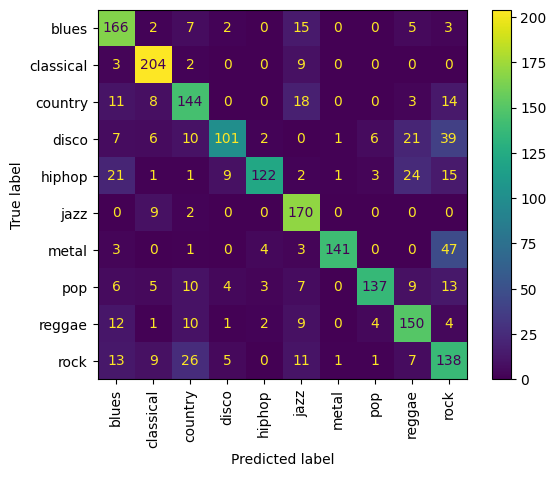

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 預測
Y_pred = cnn_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# 打印混淆矩陣
cm = confusion_matrix(Y_true, Y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=genres.keys())
cmd.plot()
plt.xticks(rotation=90)
plt.show()

**模型下載**

In [ ]:
# 儲存模型架構及權重
model_save_path = '/content/drive/MyDrive/Models/your_model_name.h5'
cnn_model.save(model_save_path)

# 儲存訓練過程中的歷史記錄（選擇性）
import pickle

history_save_path = '/content/drive/MyDrive/Models/your_model_history.pkl'
with open(history_save_path, 'wb') as file:
    pickle.dump(cnn_history.history, file)


**測試**

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from collections import Counter
# cnn model
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Models/your_model_name.h5')

genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

# 音檔
music_file = '/content/drive/MyDrive/Data/head-down-prod-madirfan-194665.mp3'


y, sr = librosa.load(music_file, mono=True)

total_duration_sec = 2 * len(y) / sr

# 切割音檔
segments = []
for i in range(int(total_duration_sec) // 2):
    start_sec = i * 2
    end_sec = start_sec + 2
    start_frame = int(start_sec * sr)
    end_frame = int(end_sec * sr)
    segment = y[start_frame:end_frame]
    segments.append(segment)

# 如果不足兩秒則忽略
if len(segments[-1]) < 2 * sr:
    segments.pop()

# 梅爾頻譜圖
processed_segments = []
for segment in segments:
    ps = librosa.feature.melspectrogram(y=segment, sr=sr, hop_length=256, n_fft=512, n_mels=64)
    ps = librosa.power_to_db(ps**2)

    # 调整形状以适应CNN模型的输入
    ps_input = ps.reshape((ps.shape[0], ps.shape[1], 1))  # ps.shape[0] 是 n_mels，ps.shape[1] 是 time_steps
    processed_segments.append(ps_input)

max_time_steps = max(ps_input.shape[1] for ps_input in processed_segments)
processed_segments = [np.pad(ps_input, ((0, 0), (0, max_time_steps - ps_input.shape[1]), (0, 0)), mode='constant') for ps_input in processed_segments]

processed_segments = np.array(processed_segments)

# 預測
predictions = cnn_model.predict(processed_segments)

predicted_classes = np.argmax(predictions, axis=1)
predicted_genres = [list(genres.keys())[pred] for pred in predicted_classes]

# 輸出每個片段的音樂類型
for i, pred_genre in enumerate(predicted_genres):
    print(f"Predicted genre for segment {i + 1}: {pred_genre}")

genre_counter = Counter(predicted_genres)

most_common_genre = genre_counter.most_common(1)[0][0]

# 投票
print(f"Most predicted genre: {most_common_genre}")


4/4 [==============================] - 0s 83ms/step
Predicted genre for segment 1: reggae
Predicted genre for segment 2: reggae
Predicted genre for segment 3: hiphop
Predicted genre for segment 4: hiphop
Predicted genre for segment 5: reggae
Predicted genre for segment 6: reggae
Predicted genre for segment 7: hiphop
Predicted genre for segment 8: hiphop
Predicted genre for segment 9: hiphop
Predicted genre for segment 10: reggae
Predicted genre for segment 11: reggae
Predicted genre for segment 12: hiphop
Predicted genre for segment 13: hiphop
Predicted genre for segment 14: hiphop
Predicted genre for segment 15: reggae
Predicted genre for segment 16: hiphop
Predicted genre for segment 17: pop
Predicted genre for segment 18: hiphop
Predicted genre for segment 19: hiphop
Predicted genre for segment 20: reggae
Predicted genre for segment 21: hiphop
Predicted genre for segment 22: reggae
Predicted genre for segment 23: hiphop
Predicted genre for segment 24: reggae
Predicted genre for segm